In [10]:
import torch
import sys
from data import get_data, gen_label
from tqdm import tqdm
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import cv2

class Process:
    def __init__(self,WindowSize):
        self.delay = 1
        self.slidingWindow = WindowSize
        self.createMatrix()

    def createMatrix(self):  
#         mat = np.random.rand(self.slidingWindow,self.slidingWindow)
#         self.TimeMatrix = torch.from_numpy(np.tril(mat,-1*self.delay))
        mat = np.random.rand(self.slidingWindow)
        self.TimeMatrix = torch.from_numpy(mat.reshape(1,self.slidingWindow))
        self.OneHotMatrix = torch.from_numpy(np.arange(0,10,1.0).reshape(10,1))

    def GetResult(self,labelBatch):
        onehot = torch.nn.functional.one_hot(labelBatch, 10).double()
#         onehot = self.make_one_hot(labelBatch,10)
        res = torch.mm(self.TimeMatrix,onehot)
    
        res = torch.mm(res,self.OneHotMatrix)
        return res

    def make_one_hot(self,input, num_classes):
        """Convert class index tensor to one hot encoding tensor.
        Args:
             input: A tensor of shape [bs, 1, *]
             num_classes: An int of number of class
        Returns:
            A tensor of shape [bs, num_classes, *]
        """
        input.unsqueeze_(1)
        shape = np.zeros((input.shape[0],num_classes))
        result = torch.from_numpy(shape)
        result = result.scatter_(1, input, 1)
        return result
    
    def CalAcc(self,outputs,labels):
        bias = 0
        for i in range(outputs.shape[0]):
            for j in range(outputs.shape[1]):
                bias += pow((outputs[i][j]-labels[i][j]),2)
        bias/=(outputs.shape[0]*outputs.shape[1])
        print("average bias:",bias)


class CLSTMModel(torch.nn.Module):
    def __init__(self,slidingWindow,InformationAdd,InformationLack):
        super(CLSTMModel, self).__init__()
        self.feature_num = 512
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512, self.feature_num)
        )

#         model = models.resnet18(pretrained=True)
# #         model.fc = nn.Identity()
#         self.cnn_layer = model
#         for p in self.parameters():
#             p.requires_grad=False
#         self.cnn_layer.fc = nn.Linear(512,self.feature_num)
        self.slidingWindow = slidingWindow
        self.InformationAdd = InformationAdd
        self.InformationLack = InformationLack
        self.lstm = nn.LSTM(self.feature_num,self.feature_num,1,batch_first=True,bidirectional=True,dropout=0.2)
        self.fc = nn.Linear(self.feature_num*2,1)
        self.slidingFc = nn.Linear(slidingWindow-self.InformationLack+self.InformationAdd,1)
        
        
    def forward(self, x):
        cnn_x = self.cnn_layer(x)
        batch = torch.zeros([0,self.slidingWindow-self.InformationLack+self.InformationAdd,self.feature_num])
        batch = batch.cuda()
        piece = torch.zeros([self.slidingWindow+self.InformationAdd-self.InformationLack,self.feature_num])
        piece = piece.cuda()
        piece[0:self.InformationAdd] = cnn_x[0:self.InformationAdd]
        for i in range(cnn_x.shape[0]-self.slidingWindow):
            piece[self.InformationAdd:] = cnn_x[i+self.InformationLack:i+self.slidingWindow]
            batch = torch.cat((batch,piece.view(1,self.slidingWindow-self.InformationLack+self.InformationAdd,self.feature_num)))
        # print("cnn_out",batch)
        # print(batch)
        # batch = self.sig(batch)
        x,hidden = self.lstm(batch)
        b,s,h = x.shape
        x = x.reshape(s*b, h) # 转换成线性层的输入格式
        x = self.fc(x)
        x = x.reshape(b,s)
        x = self.slidingFc(x)
        x = x.view(b, -1)
        return x    

slidingWindow = 50
seq_len = 50
InformationAdd = 0
InformationLack = 0
model = CLSTMModel(slidingWindow, InformationAdd, InformationLack).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
batch_size = 256
epochs = 15
delay = 30
MatrixClass = Process(slidingWindow)
pbar = tqdm(range(1, epochs+1))
gt = []
pred= []

gen_label(seq_len, batch_size, False)  # 改变参数需要重新生成label，设reset=True
train_loader, test_loader = get_data(seq_len, batch_size, delay)
for epoch in pbar:    
    for batch_index, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels[slidingWindow:len(labels)].cuda()
        if labels.shape[0]!=batch_size-slidingWindow:
            continue
        outputs = model(images)
        optimizer.zero_grad()
        loss = criterion(outputs.squeeze(1), labels)
        loss.backward()
        pbar.set_postfix({'train loss' : '{0:1.5f}'.format(loss)})
        optimizer.step()
        cost = loss.item()
        # print("train lost:",cost)
        # break
        # print(cost)


  0%|          | 0/15 [00:00<?, ?it/s, train loss=0.16951]59949
9949
100%|██████████| 15/15 [07:01<00:00, 28.09s/it, train loss=0.00914]


In [11]:
with torch.no_grad():
    for batch_index, (images, labels) in enumerate(test_loader):
        labels = labels[slidingWindow:len(labels)].cuda()
        images = images.cuda()
        if labels.shape[0]!=batch_size-slidingWindow:
            continue
        outputs = model(images)
        pred.append(outputs.squeeze(1))
        gt.append(labels)
        
        loss = criterion(outputs, labels)
        cost = loss.item()
        print(cost)
        # pbar.set_postfix({'test loss' : '{0:1.5f}'.format(loss)})


0.03403741866350174
0.027054470032453537
0.014818687923252583
0.023873835802078247
0.027091454714536667
0.011029738001525402
0.01657465286552906
0.01993492618203163
0.00991344079375267
0.020815283060073853
0.024527672678232193
0.02058129385113716
0.036702003329992294
0.02980419434607029
0.02475660853087902
0.03233538940548897
0.03521706536412239
0.020646804943680763
0.020093217492103577
0.021795691922307014
0.02464560605585575
0.026317941024899483
0.014973564073443413
0.020538415759801865
0.020241471007466316
0.02207268960773945
0.026363562792539597
0.015389634296298027
0.022330915555357933
0.01054740883409977
0.01974959671497345
0.02124708704650402
0.01693020574748516
0.015546780079603195
0.015571835450828075
0.01985994167625904
0.018052581697702408
0.021402383223176003
0.019584359601140022


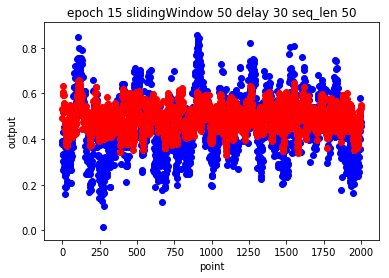

In [12]:
gt_show = [i.cpu().detach().numpy() for k in gt for i in k]
pred_show = [i.cpu().detach().numpy() for k in pred for i in k]
length = 2000
plt.scatter(list(range(length)), gt_show[0:length], c='b')
plt.scatter(list(range(length)), pred_show[0:length], c='r')
plt.xlabel('point')
plt.ylabel('output')
plt.title("epoch {} slidingWindow {} delay {} seq_len {}".format(epochs, slidingWindow, delay, slidingWindow+InformationAdd-InformationLack))
plt.show()
plt.close()

In [ ]:
pbar.close()

In [26]:
import torch
import sys
from data import train_loader, test_loader, data_train, data_test
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from torch.autograd import Variable

import cv2
slidingWindow = 5

class Process:
    def __init__(self,WindowSize):
        self.delay = 1
        self.slidingWindow = WindowSize
        self.createMatrix()

    def createMatrix(self):  
#         mat = np.random.rand(self.slidingWindow,self.slidingWindow)
#         self.TimeMatrix = torch.from_numpy(np.tril(mat,-1*self.delay))
        mat = np.random.rand(self.slidingWindow)
        self.TimeMatrix = torch.from_numpy(mat.reshape(1,self.slidingWindow))
        self.OneHotMatrix = torch.from_numpy(np.arange(0,10,1.0).reshape(10,1))

    def GetResult(self,labelBatch):
#         onehot = torch.nn.functional.one_hot(labelBatch, 10).double()
#         onehot = self.make_one_hot(labelBatch,10)
        res = torch.mm(self.TimeMatrix,labelBatch.resize(self.slidingWindow,1).double())
        
#         res = torch.mm(res,self.OneHotMatrix)
        res[0] = res[0]/50
        return res

    def make_one_hot(self,input, num_classes):
        """Convert class index tensor to one hot encoding tensor.
        Args:
             input: A tensor of shape [bs, 1, *]
             num_classes: An int of number of class
        Returns:
            A tensor of shape [bs, num_classes, *]
        """
        input.unsqueeze_(1)
        shape = np.zeros((input.shape[0],num_classes))
        result = torch.from_numpy(shape)
        result = result.scatter_(1, input, 1)
        return result
    
    def CalAcc(self,outputs,labels):
        bias = 0
        for i in range(outputs.shape[0]):
            for j in range(outputs.shape[1]):
                bias += pow((outputs[i][j]-labels[i][j]),2)
        bias/=(outputs.shape[0]*outputs.shape[1])
        print("average bias:",bias)
    
class LSTM(torch.nn.Module):
    def __init__(self,slidingWindow):
        super(LSTM, self).__init__()
        # self.cnn_layer = nn.Sequential(
        #     nn.Conv2d(3, 32, kernel_size=3),
        #     nn.ReLU(),
        #     nn.Conv2d(32, 64, kernel_size=3, stride=2),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, kernel_size=3, stride=2),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 128, kernel_size=3, stride=2),
        #     nn.ReLU(),
        #     nn.Flatten(),
        #     # nn.Linear(512, 10)
        # )
        self.feature_num = 32
        self.slidingWindow = slidingWindow
        self.lstm = nn.LSTM(1,self.feature_num*2,2,batch_first=True)
        self.fc = nn.Linear(self.feature_num*2,1)
        self.slidingFc = nn.Linear(slidingWindow,1)

    def forward(self, x):
        hidden = (torch.randn(2, 256-self.slidingWindow, self.feature_num*2).cuda(), torch.randn(2, 256-self.slidingWindow, self.feature_num*2).cuda())  # clean out hidden state
        # print("cnn_out",batch)
        # print(batch)
        # batch = self.sig(batch)
        x = x.cuda()
#         print(x)
#         sys.exit()
        x,hidden = self.lstm(x)
        b,s,h = x.shape
        x = x.reshape(s*b, h) # 转换成线性层的输入格式
        x = self.fc(x)
        x = x.reshape(b,s)
        x = self.slidingFc(x)
        x = x.view(b, -1)
        return x    

model = LSTM(slidingWindow).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

epochs = 5
MatrixClass = Process(slidingWindow)
pbar = tqdm(range(1, epochs+1))
gt = []
pred= []
for epoch in pbar:
    running_loss = 0.0
    running_correct = 0
    print("Epoch {}/{}".format(epoch, epochs))
    print("-"*10)    

    for batch_index, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        perior_result = torch.zeros([0,1])
        perior_result = perior_result.cuda()
        label_seq = torch.zeros([0,slidingWindow,1])
        for i in range(len(labels)-slidingWindow):

            result = MatrixClass.GetResult(labels[i:i+slidingWindow])
            label_seq = torch.cat((label_seq,labels[i:i+slidingWindow].view(1,slidingWindow,1).float()))
            result = result.float()
            result = result.cuda()
            perior_result = torch.cat((perior_result,result.view(1,1)))
            # image_sequence[i] = images[i:i+slidingWindow]
        if perior_result.shape[0]!=256-slidingWindow:
            print(perior_result.shape)
            continue
        # image_sequence = image_sequence.cuda()
        label_seq = Variable(label_seq)
        perior_result = Variable(perior_result)
        outputs = model(label_seq)
        # print(outputs)
        optimizer.zero_grad()

        # MatrixClass.CalAcc(outputs,perior_result)
        # print(perior_result.shape,image_sequence.shape)
        loss = criterion(outputs, perior_result)
        loss.backward()
        pbar.set_postfix({'train loss' : '{0:1.5f}'.format(loss)})
        optimizer.step()
        cost = loss.item()
        # print("train lost:",cost)
        # break
        # print(cost)



    for batch_index, (images, labels) in enumerate(test_loader):
        perior_result = torch.zeros([0,1])
        perior_result = perior_result.cuda()
        images = images.cuda()
        label_seq = torch.zeros([0,slidingWindow,1])
        for i in range(len(labels)-slidingWindow):
            result = MatrixClass.GetResult(labels[i:i+slidingWindow])
            label_seq = torch.cat((label_seq,labels[i:i+slidingWindow].view(1,slidingWindow,1).float()))
            result = result.float()
            result = result.cuda()
            perior_result = torch.cat((perior_result,result.view(1,1)))
        if perior_result.shape[0]!=256-slidingWindow:
            print(perior_result.shape)
            continue
        # image_sequence = image_sequence.cuda()
        outputs = model(label_seq)
        pred = outputs
        # print(outputs)
        gt = perior_result
        # MatrixClass.CalAcc(outputs,perior_result)
        # print(perior_result.shape,image_sequence.shape)
        loss = criterion(outputs, perior_result)
        cost = loss.item()
        pbar.set_postfix({'test loss' : '{0:1.5f}'.format(loss)})


  0%|          | 0/5 [00:00<?, ?it/s]/home/cmq/anaconda2/lib/python2.7/site-packages/torch/tensor.py:330: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 1/5
----------


  0%|          | 0/5 [00:15<?, ?it/s, test loss=0.00418] 

torch.Size([91, 1])


 20%|██        | 1/5 [00:17<01:09, 17.29s/it, train loss=0.00484]

torch.Size([11, 1])
Epoch 2/5
----------


 20%|██        | 1/5 [00:31<01:09, 17.29s/it, test loss=0.00436] 

torch.Size([91, 1])


 40%|████      | 2/5 [00:33<00:51, 17.01s/it, train loss=0.00362]

torch.Size([11, 1])
Epoch 3/5
----------


 40%|████      | 2/5 [00:47<00:51, 17.01s/it, test loss=0.00284] 

torch.Size([91, 1])


 60%|██████    | 3/5 [00:50<00:33, 16.83s/it, train loss=0.00274]

torch.Size([11, 1])
Epoch 4/5
----------


 60%|██████    | 3/5 [01:04<00:33, 16.83s/it, test loss=0.00186] 

torch.Size([91, 1])


 80%|████████  | 4/5 [01:06<00:16, 16.64s/it, train loss=0.00197]

torch.Size([11, 1])
Epoch 5/5
----------


 80%|████████  | 4/5 [01:20<00:16, 16.64s/it, test loss=0.00164] 

torch.Size([91, 1])


100%|██████████| 5/5 [01:22<00:00, 16.45s/it, test loss=0.00119]

torch.Size([11, 1])


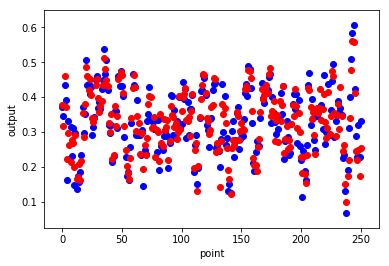

In [27]:
gt_show = gt.cpu().detach().numpy()
pred_show = pred.cpu().detach().numpy()
plt.scatter(list(range(len(gt_show))), gt_show, c='b')
plt.scatter(range(len(pred_show)), pred_show, c='r')
plt.xlabel('point')
plt.ylabel('output')
plt.show()
plt.close()


In [8]:
class Process:
    def __init__(self,WindowSize):
        self.delay = 1
        self.slidingWindow = WindowSize
        self.createMatrix()

    def createMatrix(self):  
#         mat = np.random.rand(self.slidingWindow,self.slidingWindow)
#         self.TimeMatrix = torch.from_numpy(np.tril(mat,-1*self.delay))
        mat = np.random.rand(self.slidingWindow)
        self.TimeMatrix = torch.from_numpy(mat.reshape(1,self.slidingWindow))
        self.OneHotMatrix = torch.from_numpy(np.arange(0,10,1.0).reshape(10,1))

    def GetResult(self,labelBatch):
#         onehot = torch.nn.functional.one_hot(labelBatch, 10).double()
#         onehot = self.make_one_hot(labelBatch,10)
        res = torch.mm(self.TimeMatrix,labelBatch.resize(self.slidingWindow,1).double())
        
#         res = torch.mm(res,self.OneHotMatrix)
        res[0] = res[0]/70
        return res

    def make_one_hot(self,input, num_classes):
        """Convert class index tensor to one hot encoding tensor.
        Args:
             input: A tensor of shape [bs, 1, *]
             num_classes: An int of number of class
        Returns:
            A tensor of shape [bs, num_classes, *]
        """
        input.unsqueeze_(1)
        shape = np.zeros((input.shape[0],num_classes))
        result = torch.from_numpy(shape)
        result = result.scatter_(1, input, 1)
        return result
    
    def CalAcc(self,outputs,labels):
        bias = 0
        for i in range(outputs.shape[0]):
            for j in range(outputs.shape[1]):
                bias += pow((outputs[i][j]-labels[i][j]),2)
        bias/=(outputs.shape[0]*outputs.shape[1])
        print("average bias:",bias)


157
Epoch: 356, Loss: 0.0000054529
Epoch: 357, Loss: 0.0000280724
Epoch: 358, Loss: 0.0000435589
Epoch: 359, Loss: 0.0000147499
Epoch: 360, Loss: 0.0000051549
Epoch: 361, Loss: 0.0000270309
Epoch: 362, Loss: 0.0000272300
Epoch: 363, Loss: 0.0000062842
Epoch: 364, Loss: 0.0000059078
Epoch: 365, Loss: 0.0000208570
Epoch: 366, Loss: 0.0000188309
Epoch: 367, Loss: 0.0000049077
Epoch: 368, Loss: 0.0000046083
Epoch: 369, Loss: 0.0000145220
Epoch: 370, Loss: 0.0000139580
Epoch: 371, Loss: 0.0000045317
Epoch: 372, Loss: 0.0000030739
Epoch: 373, Loss: 0.0000094323
Epoch: 374, Loss: 0.0000100033
Epoch: 375, Loss: 0.0000039087
Epoch: 376, Loss: 0.0000022399
Epoch: 377, Loss: 0.0000063206
Epoch: 378, Loss: 0.0000071420
Epoch: 379, Loss: 0.0000032912
Epoch: 380, Loss: 0.0000020095
Epoch: 381, Loss: 0.0000046647
Epoch: 382, Loss: 0.0000053712
Epoch: 383, Loss: 0.0000028820
Epoch: 384, Loss: 0.0000019525
Epoch: 385, Loss: 0.0000036523
Epoch: 386, Loss: 0.0000041979
Epoch: 387, Loss: 0.0000025879
Epoc

&lt;matplotlib.legend.Legend at 0x7f5c4802f550&gt;

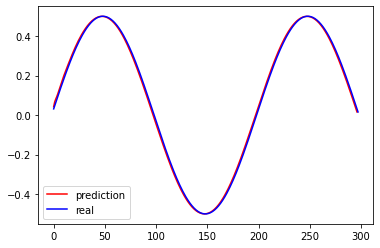

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb  5 19:51:23 2018

@author: Maohan
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt#matplotlib inline
import math
dataset=[]
for data in np.arange(0, 3, .01):
    data = math.sin(data*math.pi)
    dataset.append(data)
dataset=np.array(dataset)
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))



def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(dataset)

train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

import torch

train_X = train_X.reshape(-1, 1, 3)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 3)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)
from torch import nn
from torch.autograd import Variable
# 定义模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # 回归
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # 转换成线性层的输入格式
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x
net = lstm_reg(3, 20)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
# 开始训练
for e in range(1000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#     if (e + 1) % 100 == 0: # 每 100 次输出结果
    print('Epoch: {}, Loss: {:.10f}'.format(e + 1, loss.item()))
net = net.eval() # 转换成测试模式
data_X = data_X.reshape(-1, 1, 3)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = net(var_data) # 测试集的预测结果
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()
# 画出实际结果和预测的结果
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset[2:], 'b', label='real')
plt.legend(loc='best')